In [38]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import StandardScaler, LabelEncoder
from sklearn.cluster import KMeans, AgglomerativeClustering, DBSCAN
from sklearn.decomposition import PCA
from sklearn.manifold import TSNE
from sklearn.metrics import silhouette_score
import scipy.cluster.hierarchy as sch

In [39]:
df = pd.read_csv("Mall_Customers.csv")
df.head()

,CustomerID,Genre,Age,Annual Income (k$),Spending Score (1-100)
0,1,Male,19,15,39
1,2,Male,21,15,81
2,3,Female,20,16,6
3,4,Female,23,16,77
4,5,Female,31,17,40


In [40]:
df.info()
df.describe()
df.columns

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 200 entries, 0 to 199
Data columns (total 5 columns):
 #   Column                  Non-Null Count  Dtype 
---  ------                  --------------  ----- 
 0   CustomerID              200 non-null    int64 
 1   Genre                   200 non-null    object
 2   Age                     200 non-null    int64 
 3   Annual Income (k$)      200 non-null    int64 
 4   Spending Score (1-100)  200 non-null    int64 
dtypes: int64(4), object(1)
memory usage: 7.9+ KB


Index(['CustomerID', 'Genre', 'Age', 'Annual Income (k$)',
       'Spending Score (1-100)'],
      dtype='object')

In [41]:
missing = df.isna().sum()
print(missing)

CustomerID                0
Genre                     0
Age                       0
Annual Income (k$)        0
Spending Score (1-100)    0
dtype: int64


In [42]:
df.dtypes

CustomerID                 int64
Genre                     object
Age                        int64
Annual Income (k$)         int64
Spending Score (1-100)     int64
dtype: object

In [43]:
# 1. Drop CustomerID (not a feature)
df_clean = df.drop('CustomerID', axis=1)

# 2. Encode categorical 'Genre' (Gender) to numerical
le = LabelEncoder()
df_clean['Genre'] = le.fit_transform(df_clean['Genre'])

# 3. Check for nulls (already confirmed none, but good practice)
print("Missing values:\n", df_clean.isnull().sum())

# 4. Feature Scaling (Essential for distance-based clustering)
scaler = StandardScaler()
scaled_data = scaler.fit_transform(df_clean)

print("Preprocessing complete. Data scaled.")

Missing values:
 Genre                     0
Age                       0
Annual Income (k$)        0
Spending Score (1-100)    0
dtype: int64
Preprocessing complete. Data scaled.


In [44]:
# PCA for linear dimensionality reduction
pca = PCA(n_components=2)
pca_data = pca.fit_transform(scaled_data)

# t-SNE for non-linear dimensionality reduction
tsne = TSNE(n_components=2, random_state=42)
tsne_data = tsne.fit_transform(scaled_data)

print("Dimensionality reduction complete.")

Dimensionality reduction complete.


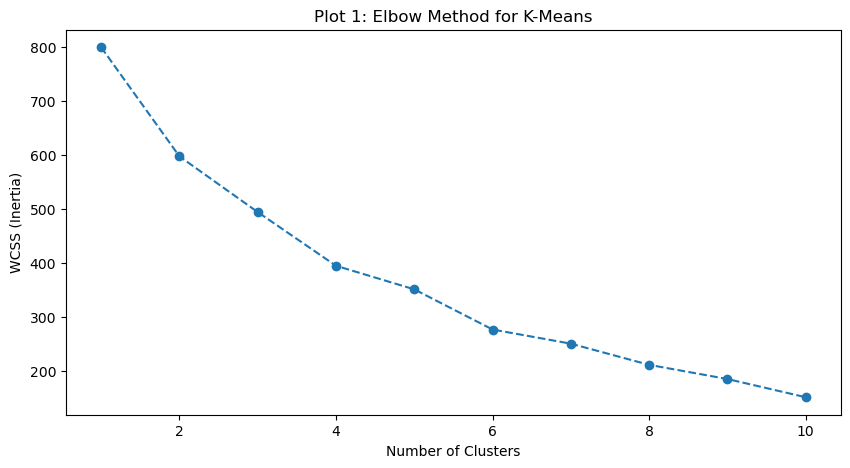

In [45]:
# Elbow Method to find optimal k
wcss = []
for i in range(1, 11):
    kmeans = KMeans(n_clusters=i, init='k-means++', random_state=42)
    kmeans.fit(scaled_data)
    wcss.append(kmeans.inertia_)

# Plotting the Elbow Method
plt.figure(figsize=(10, 5))
plt.plot(range(1, 11), wcss, marker='o', linestyle='--')
plt.title('Plot 1: Elbow Method for K-Means')
plt.xlabel('Number of Clusters')
plt.ylabel('WCSS (Inertia)')
plt.show()

# Based on the elbow, choosing k=5
kmeans = KMeans(n_clusters=5, init='k-means++', random_state=42)
kmeans_labels = kmeans.fit_predict(scaled_data)

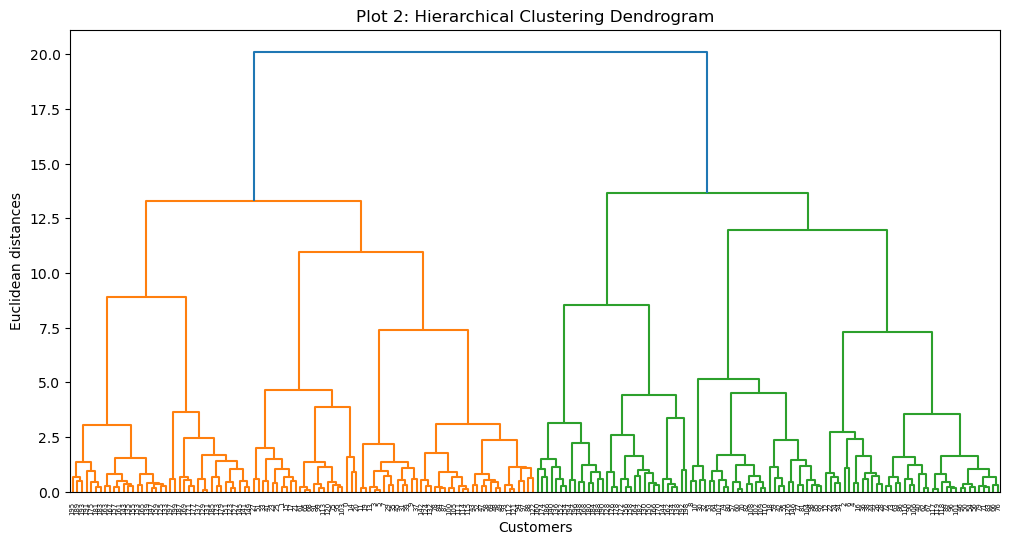

In [46]:
# Plotting the Dendrogram
plt.figure(figsize=(12, 6))
dendrogram = sch.dendrogram(sch.linkage(scaled_data, method='ward'))
plt.title('Plot 2: Hierarchical Clustering Dendrogram')
plt.xlabel('Customers')
plt.ylabel('Euclidean distances')
plt.show()

# Fitting Agglomerative Clustering
hierarchical = AgglomerativeClustering(n_clusters=5)
hier_labels = hierarchical.fit_predict(scaled_data)

In [47]:
# DBSCAN (eps and min_samples need tuning)
dbscan = DBSCAN(eps=0.5, min_samples=5)
dbscan_labels = dbscan.fit_predict(scaled_data)

print("DBSCAN fitting complete.")

DBSCAN fitting complete.


In [48]:
# Calculating Silhouette Scores (Higher is better, range -1 to 1)
score_kmeans = silhouette_score(scaled_data, kmeans_labels)
score_hier = silhouette_score(scaled_data, hier_labels)

# DBSCAN might treat points as noise (-1), which can't be used alone for silhouette if only 1 cluster is found
if len(set(dbscan_labels)) > 1:
    score_dbscan = silhouette_score(scaled_data, dbscan_labels)
else:
    score_dbscan = 0

print(f"K-Means Silhouette Score: {score_kmeans:.4f}")
print(f"Hierarchical Silhouette Score: {score_hier:.4f}")
print(f"DBSCAN Silhouette Score: {score_dbscan:.4f}")

K-Means Silhouette Score: 0.2719
Hierarchical Silhouette Score: 0.2870
DBSCAN Silhouette Score: 0.0120


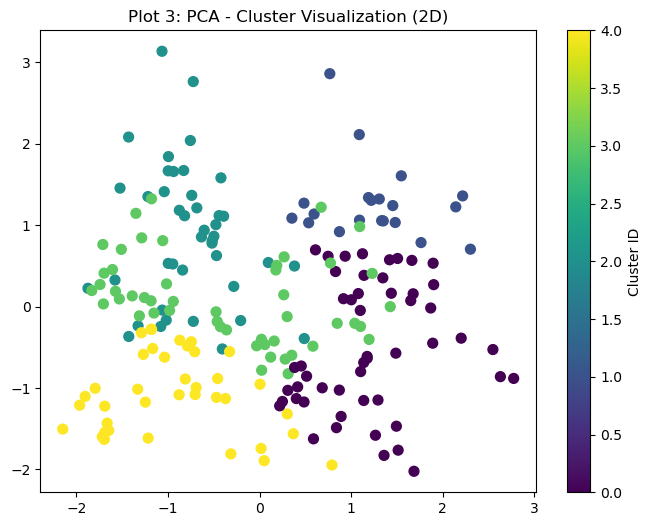

In [49]:
# Plot 3: PCA Cluster Visualization
plt.figure(figsize=(8, 6))
plt.scatter(pca_data[:, 0], pca_data[:, 1], c=kmeans_labels, cmap='viridis', s=50)
plt.title('Plot 3: PCA - Cluster Visualization (2D)')
plt.colorbar(label='Cluster ID')
plt.show()

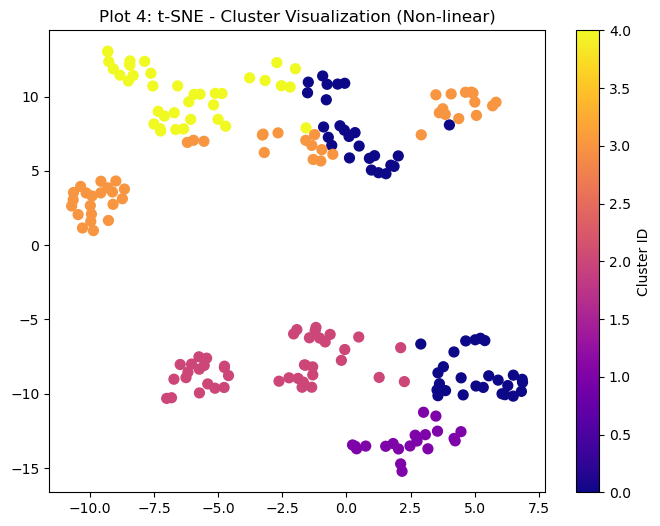

In [50]:
# Plot 4: t-SNE Cluster Visualization
plt.figure(figsize=(8, 6))
plt.scatter(tsne_data[:, 0], tsne_data[:, 1], c=kmeans_labels, cmap='plasma', s=50)
plt.title('Plot 4: t-SNE - Cluster Visualization (Non-linear)')
plt.colorbar(label='Cluster ID')
plt.show()

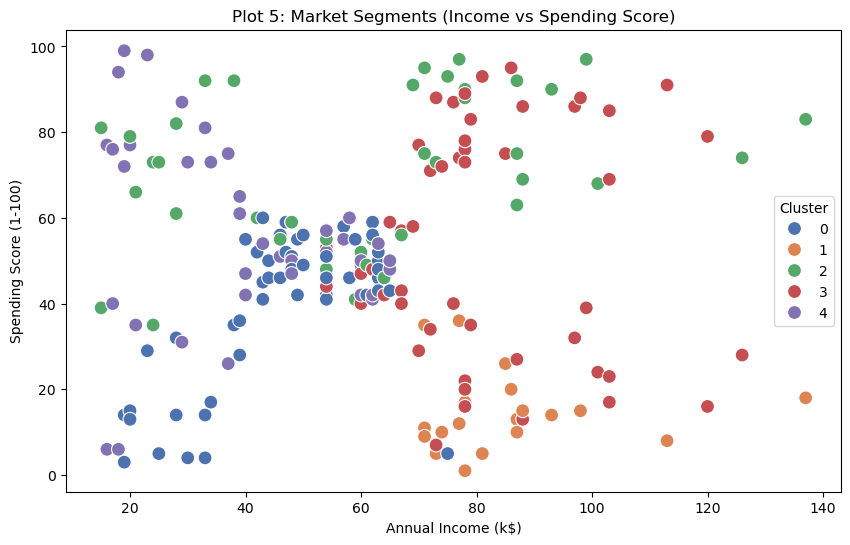

In [51]:
# Plot 5: Annual Income vs Spending Score
plt.figure(figsize=(10, 6))
sns.scatterplot(x=df['Annual Income (k$)'], y=df['Spending Score (1-100)'], 
                hue=kmeans_labels, palette='deep', s=100)
plt.title('Plot 5: Market Segments (Income vs Spending Score)')
plt.legend(title='Cluster')
plt.show()

In [52]:
# Add the K-Means labels to the original dataframe
df['Cluster'] = kmeans_labels

# Mapping cluster IDs to human-readable segments (based on Plot 5 analysis)
# Note: The exact ID mapping depends on the random initialization
# Typical segments: 0: Standard, 1: High Income/Low Spend, 2: Target (High Income/High Spend), 3: Careless, 4: Sensible
df.to_csv('Customer_Segments.csv', index=False)

print("Project Complete! The clustered data has been saved to 'Customer_Segments.csv'.")
df.head()

Project Complete! The clustered data has been saved to 'Customer_Segments.csv'.


,CustomerID,Genre,Age,Annual Income (k$),Spending Score (1-100),Cluster
0,1,Male,19,15,39,2
1,2,Male,21,15,81,2
2,3,Female,20,16,6,4
3,4,Female,23,16,77,4
4,5,Female,31,17,40,4
